<a href="https://colab.research.google.com/github/donaldssh/3DAR_project_descriptors/blob/autoencoder/Surf_Autoencoder_3Ddesc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is meant to be used only for **experimenting and training the model**.
The actual compression on the decriptor will be carried out by a standard python script, that uses a pretrained model.


Or import dataset from drive

In [2]:
#warning: this only work for Daniele drive for now

! unzip /content/drive/MyDrive/UNI_ICT/3DAR/descriptors_dataset.zip

Archive:  /content/drive/MyDrive/UNI_ICT/3DAR/descriptors_dataset.zip
   creating: descriptors_dataset/
  inflating: descriptors_dataset/test_set.bin  
  inflating: descriptors_dataset/train_set.bin  


Import libraries

In [3]:
!pip install --quiet optuna


     |████████████████████████████████| 266kB 9.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 7.2MB/s 
     |████████████████████████████████| 163kB 14.3MB/s 
     |████████████████████████████████| 133kB 12.8MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 112kB 16.0MB/s 
     |████████████████████████████████| 81kB 8.9MB/s 


In [4]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import notebook, tqdm # this module is useful to plot progress bars
from sklearn.decomposition import PCA
import json
import numba

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from torchvision import transforms
import torchvision
import optuna

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")
torch.manual_seed(0)

Training device: cuda


load binary file with descriptor as dataframe

In [5]:
train_path = '/content/descriptors_dataset/train_set.bin'
test_path = '/content/descriptors_dataset/test_set.bin'

train_raw = np.fromfile(train_path, dtype='float32')
test_raw = np.fromfile(test_path, dtype='float32')
print(np.shape(train_raw), np.shape(test_raw))

train_set = np.reshape(train_raw, (np.shape(train_raw)[0]//128,128))
test_set = np.reshape(test_raw, (np.shape(test_raw)[0]//128,128))
print(np.shape(train_set), np.shape(test_set))

# convert in dataframe
train_set = pd.DataFrame(train_set)
test_set = pd.DataFrame(test_set)
train_set

(10734848,) (40188800,)
(83866, 128) (313975, 128)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,0.003977,0.004094,0.001158,0.001211,0.002178,0.003975,0.000147,0.000201,0.001390,0.003913,-0.000623,0.002208,0.005872,0.008583,-0.002544,0.015829,0.000715,0.002617,-0.000757,0.000757,0.011567,0.011567,-0.002198,0.011475,0.000259,0.001516,-0.000049,0.000125,0.001687,0.001793,0.000211,0.001526,0.005941,0.026585,0.003818,0.005092,0.011648,0.012168,0.009961,0.013242,...,-0.013263,0.021591,-0.025073,0.028366,0.001998,0.004193,-0.001465,0.010882,0.000015,0.000258,-0.000728,0.004353,-0.003504,0.005917,-0.005797,0.007094,0.007245,0.008251,0.002095,0.026427,-0.014260,0.066804,-0.009374,0.013389,0.021637,0.024003,0.012856,0.017909,-0.005929,0.052598,-0.001135,0.002862,-0.000623,0.002579,-0.003556,0.008000,-0.000592,0.001290,-0.003214,0.004261
1,-0.000293,0.000293,-0.003658,0.004107,-0.000295,0.000295,-0.000710,0.000769,0.015767,0.016046,0.000607,0.000941,0.023647,0.026446,0.001809,0.002040,-0.001588,0.014385,0.000764,0.000764,0.009594,0.014873,0.036861,0.036861,-0.000197,0.000770,-0.000178,0.001410,-0.001487,0.002953,-0.000460,0.001125,-0.006272,0.009139,-0.016423,0.016775,0.000807,0.001474,-0.001565,0.004249,...,0.000827,0.001472,-0.003930,0.010274,-0.001455,0.004035,-0.016245,0.017724,-0.002277,0.002452,-0.001581,0.001704,-0.000149,0.000339,0.000090,0.000613,0.013206,0.013767,0.026404,0.026404,-0.019698,0.027909,0.001750,0.001750,-0.002019,0.013576,-0.011187,0.014943,0.003926,0.012494,0.004074,0.019268,-0.000081,0.000118,0.000700,0.001190,-0.004601,0.004902,-0.000284,0.001319
2,0.010813,0.010813,0.000291,0.000291,0.001760,0.005130,0.000000,0.000000,0.000241,0.007325,0.026263,0.030316,-0.013533,0.018234,0.002195,0.005281,-0.007102,0.018575,0.005042,0.006173,0.012045,0.015462,0.017483,0.018600,-0.014475,0.014626,0.000003,0.000409,-0.000145,0.000187,0.009671,0.009992,0.015915,0.040549,0.007860,0.017681,0.039719,0.042033,0.003356,0.017884,...,-0.004884,0.006757,-0.005454,0.007741,0.000582,0.005033,0.001032,0.011677,-0.001195,0.001386,-0.000056,0.001444,-0.000080,0.001088,-0.001439,0.005315,0.002129,0.007017,-0.008177,0.023996,-0.029093,0.031962,-0.021619,0.038434,0.003283,0.006301,0.033493,0.038111,-0.083176,0.085348,-0.011287,0.011530,0.000288,0.000288,0.002962,0.003077,-0.005183,0.005271,-0.000026,0.000026
3,0.005997,0.006357,0.000054,0.000306,0.001673,0.002640,0.000307,0.000543,0.009311,0.011456,-0.001183,0.001958,0.014703,0.022361,-0.004418,0.018720,0.001868,0.003555,-0.001477,0.001626,0.012298,0.012566,-0.004839,0.015172,0.000370,0.000543,-0.000222,0.000250,0.002694,0.002854,-0.000972,0.001394,0.049242,0.053013,0.009259,0.019462,0.022581,0.026116,-0.010796,0.013292,...,0.022688,0.024289,0.005790,0.005790,-0.000733,0.017632,0.005675,0.005675,-0.000323,0.000536,-0.003245,0.003951,-0.001064,0.001335,-0.003917,0.004029,0.006944,0.006959,0.010044,0.012008,0.012423,0.036095,-0.003238,0.003282,0.018653,0.034861,-0.001061,0.011504,0.010193,0.040627,-0.013101,0.014622,0.004226,0.004396,0.004223,0.004724,-0.002316,0.006061,-0.000327,0.001271
4,-0.003744,0.004577,0.003334,0.007550,0.000702,0.001265,0.001506,0.002862,-0.025747,0.031493,0.000575,0.003369,-0.000589,0.000589,0.003023,0.003702,0.003578,0.005398,0.000923,0.003605,0.002636,0.005576,-0.003938,0.004637,-0.001479,0.001509,0.000000,0.000000,0.000040,0.000040,0.005008,0.005008,0.031937,0.035476,0.022561,0.033477,0.004729,0.036002,-0.006248,0.007834,...,-0.047558,0.049634,-0.000394,0.006985,-0.001230,0.003997,0.011124,0.011651,0.006029,0.006036,0.001956,0.001956,0.000320,0.002108,0.000001,0.000001,0.000343,0.031619,0.024123,0.055669,-0.012209,0.032383,0.003623,0.007440,-0.017665,0.030742,0.009345,0.024186,-0.004515,0.016965,0.002319,0.015140,-0.004457,0.005334,-0.000316,0.000371,0.000147,0.000629,0.000537,0.001126
...,...,...,...,

# Analysis on the descriptors structure

Knowing the SURF algorithm, can we find regularities and exploit them for the design of a more efficient autoencoder?

opencv implementation about the writing of the 128 bin descriptor.
From https://github.com/opencv/opencv_contrib/blob/master/modules/xfeatures2d/src/surf.cpp at line 795

```
// 128-bin descriptor
                for( i = 0; i < 4; i++ )
                    for( j = 0; j < 4; j++ )
                    {
                        for(int y = i*5; y < i*5+5; y++ )
                        {
                            for(int x = j*5; x < j*5+5; x++ )
                            {
                                float tx = DX[y][x], ty = DY[y][x];
                                if( ty >= 0 )
                                {
                                    vec[0] += tx;
                                    vec[1] += (float)fabs(tx);
                                } else {
                                    vec[2] += tx;
                                    vec[3] += (float)fabs(tx);
                                }
                                if ( tx >= 0 )
                                {
                                    vec[4] += ty;
                                    vec[5] += (float)fabs(ty);
                                } else {
                                    vec[6] += ty;
                                    vec[7] += (float)fabs(ty);
                                }
                            }
                        }
                        for( kk = 0; kk < 8; kk++ )
                            square_mag += vec[kk]*vec[kk];
                        vec += 8;
                    }
```



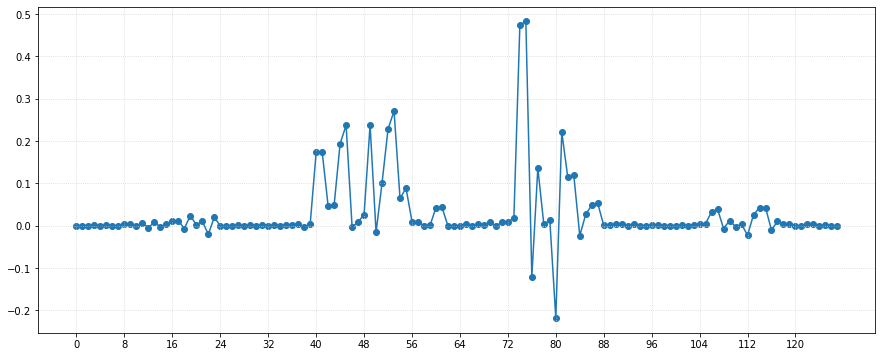

In [5]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_xticks(np.arange(0,128,8))
ax.scatter(range(128),train_set.iloc[10,:])
ax.plot(range(128), train_set.iloc[10,:])
ax.grid(color='lightgray', linestyle=':')

Visualize the superposition of many random chosen descriptors

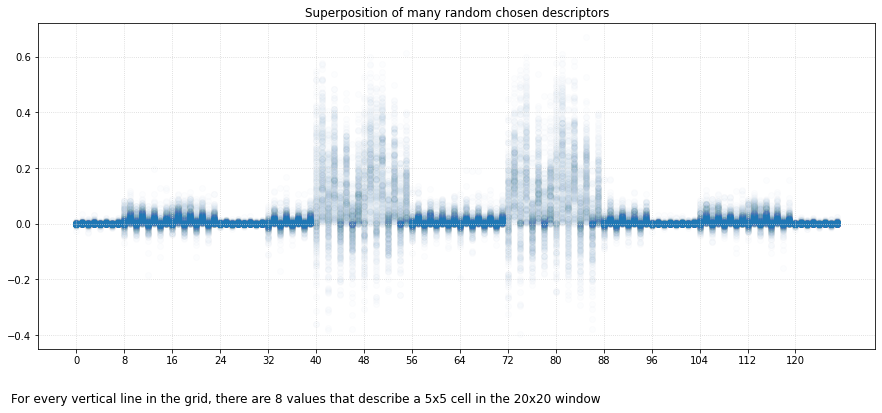

In [6]:

fig, ax = plt.subplots(figsize=(15,6))

for i in range(300):
    n = int(np.ceil(np.random.uniform()*len(train_set)))
    # ax.plot(range(128), train_set.iloc[n,:], alpha=0.01, color='#1f77b4')
    ax.scatter(range(128), train_set.iloc[n,:], alpha=0.01, color='#1f77b4')
    ax.set_xticks(np.arange(0,128,8))
    ax.grid(color='lightgray', linestyle=':')
ax.set_title("Superposition of many random chosen descriptors")
plt.figtext(0.1,0,'For every vertical line in the grid, there are 8 values that describe a 5x5 cell in the 20x20 window', fontsize = 12)
plt.show()

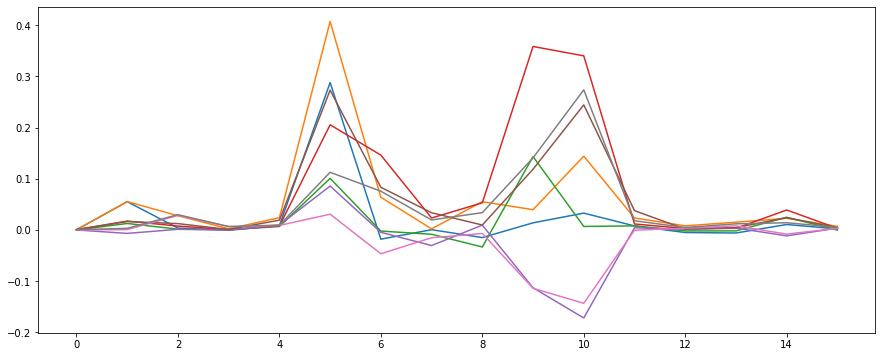

In [7]:
fig, ax = plt.subplots(figsize=(15,6))

for i in range(1):
    n = int(np.ceil(np.random.uniform()*len(train_set)))
    # ax.plot(range(128), train_set.iloc[n,:], alpha=0.01, color='#1f77b4')
    sample = train_set.iloc[n,:].to_numpy().reshape(16,8)
    ax.plot(sample)

    # ax.scatter(range(128), train_set.iloc[n,:], alpha=0.01, color='#1f77b4')
    # ax.set_xticks(np.arange(0,128,8))
    # ax.grid(color='lightgray', linestyle=':')
# ax.set_title("Superposition of many random chosen descriptors")
# plt.figtext(0.1,0,'For every vertical line in the grid, there are 8 values that describe a 5x5 cell in the 20x20 window', fontsize = 12)
# plt.show()

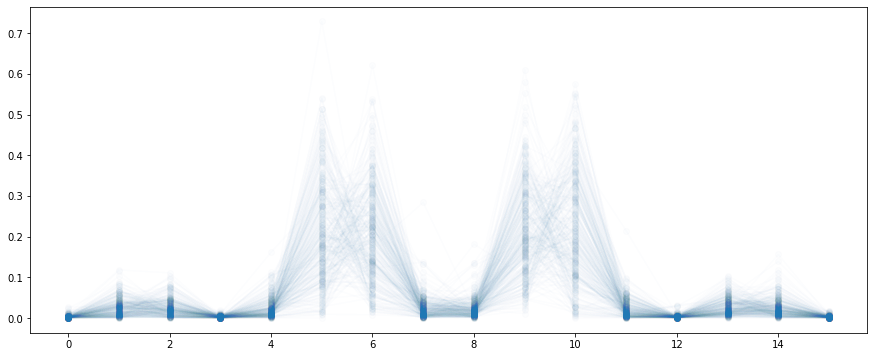

In [8]:
fig, ax = plt.subplots(figsize=(15,6))

for i in range(300):
    n = int(np.ceil(np.random.uniform()*len(train_set)))
    ax.plot(range(128//8), train_set.iloc[n,1:129:8], alpha=0.01, color='#1f77b4')
    ax.scatter(range(128//8), train_set.iloc[n,1:129:8], alpha=0.01, color='#1f77b4')


# Dataset preparation

normalize transformation class

In [6]:
class NpToTensor():
    def __call__(self, array):
        return torch.from_numpy(array)


reshaping 3D

In [7]:
class Surf3DReshape():
    def __call__(self, desc):
        channels = []
        for i in range(8):
            channels.append(np.reshape(desc[i:128:8], (4,4)))
        channels = np.dstack(channels)
        channels = np.transpose(channels, (2,0,1))
        return channels


In [8]:
print(np.max(train_raw), np.min(train_raw))
print(np.max(test_raw), np.min(test_raw))

0.80932486 -0.53642845
0.88342446 -0.5417158


Define descriptor dataset class

In [9]:
class SurfDataset(Dataset):

    def __init__(self, data, transform=None):
        self.transform = transform
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        #return a nparray from the dataframe
        sample = self.data.iloc[idx,:].to_numpy()
        if self.transform:
            sample = self.transform(sample)
        return sample

composed_transform = transforms.Compose([Surf3DReshape(), NpToTensor()])
to_tensor = NpToTensor()



In [10]:
train3D_dataset = SurfDataset(train_set, transform=composed_transform)
test3D_dataset = SurfDataset(test_set, transform=composed_transform)

print(np.shape(train3D_dataset.__getitem__(100)))

train3D_dataset, val3D_dataset = random_split(train3D_dataset, [int(0.8*len(train3D_dataset)), len(train3D_dataset)-int(0.8*len(train3D_dataset))])

torch.Size([8, 4, 4])


In [11]:
trainLin_dataset = SurfDataset(train_set, transform=to_tensor)
testLin_dataset = SurfDataset(test_set, transform=to_tensor)

print(np.shape(trainLin_dataset.__getitem__(100)))

trainLin_dataset, valLin_dataset = random_split(trainLin_dataset, [int(0.8*len(trainLin_dataset)), len(trainLin_dataset)-int(0.8*len(trainLin_dataset))])

torch.Size([128])


# Autoencoder models

## Convolutional model

In [13]:
class EncoderConv(nn.Module):
    
    def __init__(self, encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(8, conv1_ch, 3, stride=1, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(conv1_ch, conv2_ch, 3, stride=1, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(conv2_ch, conv3_ch, 3, stride=1, padding=0),  #make it 3x3
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(2 * 2 * conv3_ch, fc_ch),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(fc_ch, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        # print(np.shape(x))
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x


class DecoderConv(nn.Module):
    
    def __init__(self, encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, fc_ch),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(fc_ch, 2 * 2 * conv3_ch),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(conv3_ch, 2, 2))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(conv3_ch, conv2_ch, 3, stride=1, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(conv2_ch, conv1_ch, 3, stride=1, padding=1, output_padding=0),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(conv1_ch, 8, 3, stride=1, padding=1, output_padding=0)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # print(np.shape(x))
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # # Apply a sigmoid to force the output to be between 0 and 1 
        # x = torch.sigmoid(x)
        return x


encoder = EncoderConv(2, 16, 32,64, 50)
decoder = DecoderConv(2, 16, 32,64, 50)

sample = train3D_dataset.__getitem__(10).unsqueeze(0)
print(np.shape(sample))

output = decoder(encoder(sample))
print(np.shape(output))

torch.Size([1, 8, 4, 4])
torch.Size([1, 8, 4, 4])


## Linear model

In [14]:
class EncoderLin(nn.Module):
    
    def __init__(self, encoded_space_dim, fc1_ch, fc2_ch, fc3_ch, fc4_ch):
        super().__init__()

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(128, fc1_ch),
            nn.ReLU(True),
            # nn.BatchNorm1d(fc1_ch)
            # Second linear layer
            nn.Linear(fc1_ch, fc2_ch),
            nn.ReLU(True),
            # Third linear level
            nn.Linear(fc2_ch, fc3_ch),
            nn.ReLU(True),
            nn.Linear(fc3_ch, fc4_ch),
            nn.ReLU(True),
            nn.Linear(fc4_ch, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.encoder_lin(x)
        return x


class DecoderLin(nn.Module):
    
    def __init__(self, encoded_space_dim, fc1_ch, fc2_ch, fc3_ch, fc4_ch):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, fc4_ch),
            nn.ReLU(True),
            nn.Linear(fc4_ch, fc3_ch),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(fc3_ch, fc2_ch),
            nn.ReLU(True),
            nn.Linear(fc2_ch, fc1_ch),
            nn.ReLU(True),
            nn.Linear(fc1_ch, 128)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        return x

# Training preparation

In [15]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for surf_batch in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        surf_batch = surf_batch.to(device)
        # Encode data
        encoded_data = encoder(surf_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, surf_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        # print('\t partial train loss (single batch): %f' % (loss.data))
    
    return loss.data

In [16]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for surf_batch in dataloader:
            # Move tensor to the proper device
            surf_batch = surf_batch.to(device)
            # Encode data
            encoded_data = encoder(surf_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(surf_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

# Parameters search with Optuna

## trying 16 dimension latent space

In [17]:
def objective(trial):

    #suggest parameters
    # encoded_space_dim = trial.suggest_int('encoded_space_dim', 2,10)
    encoded_space_dim = 16
    batch_size = trial.suggest_int('batch_size', 200, 1000)
    # optim = trial.suggest_categorical('optim', ['Adam', 'SGD'])
    architecture = trial.suggest_categorical('architecture', ['Linear', 'Conv'])
    conv1_ch = trial.suggest_int('conv1_ch', 32, 128)
    conv2_ch = trial.suggest_int('conv2_ch', 32,128)
    conv3_ch = trial.suggest_int('conv3_ch', 32,128)
    fc_ch = trial.suggest_int('fc_ch', 32,128)
    
    # initialize models
    if architecture == 'Conv':
        encoder = EncoderConv(encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch)
        decoder = DecoderConv(encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch)
        
        train_dataloader = DataLoader(train3D_dataset_reduced, batch_size=batch_size, shuffle=True)
        val_dataloader = DataLoader(val3D_dataset_reduced, batch_size=batch_size, shuffle=False)

    elif architecture == 'Linear':
        encoder = EncoderLin(encoded_space_dim, conv1_ch*9, conv2_ch*9, conv3_ch*9, fc_ch*9)
        decoder = DecoderLin(encoded_space_dim, conv1_ch*9, conv2_ch*9, conv3_ch*9, fc_ch*9)

        train_dataloader = DataLoader(trainLin_dataset_reduced, batch_size=batch_size, shuffle=True)
        val_dataloader = DataLoader(valLin_dataset_reduced, batch_size=batch_size, shuffle=False)



    ### Define the loss function
    loss_fn = torch.nn.MSELoss()

    ### Define an optimizer (both for the encoder and the decoder!)
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
    params_to_optimize = [
        {'params': encoder.parameters()},
        {'params': decoder.parameters()}
    ]

    optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

    
    # Move both the encoder and the decoder to the selected device
    encoder.to(device)
    decoder.to(device)


    # Training Loop
    display = False
    num_epochs = 50 

    train_loss_record = []
    val_loss_record = []
    for epoch in notebook.tqdm(range(num_epochs)):
        if display:
            print('EPOCH: %d/%d' % (epoch + 1, num_epochs))

        train_loss_batch_record = []
        val_loss_batch_record = []
        ### Training (use the training function)
        train_loss_batch = train_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn, 
            optimizer=optim)
        train_loss_batch_record.append(train_loss_batch)
        ### Validation  (use the testing function)
        val_loss_batch = test_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=val_dataloader, 
            loss_fn=loss_fn)
        val_loss_batch_record.append(val_loss_batch)
        if display:
        # Print Validationloss
            print('\n\n\t TRAINING - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, 
                                                                    sum(train_loss_batch_record)/len(train_loss_batch_record)))
            print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss_batch))

        #store losses for this epoch
        train_loss_record.append(sum(train_loss_batch_record)/len(train_loss_batch_record))
        val_loss_record.append(sum(val_loss_batch_record)/len(val_loss_batch_record))



        # call back optuna for pruning
        trial.report(sum(val_loss_batch_record)/len(val_loss_batch_record), epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()
        #end of training loop
    
    final_val_loss = val_loss_record[-1]
    

    
    return final_val_loss

In [18]:
#use reduced datasets for speed 
rtrain_size = 10000
rval_size = 2000
train3D_dataset_reduced, _ = random_split(train3D_dataset, [rtrain_size, len(train3D_dataset)-rtrain_size])
val3D_dataset_reduced, _ = random_split(val3D_dataset, [rval_size, len(val3D_dataset)-rval_size])


trainLin_dataset_reduced, _ = random_split(trainLin_dataset, [rtrain_size, len(trainLin_dataset)-rtrain_size])
valLin_dataset_reduced, _ = random_split(valLin_dataset, [rval_size, len(valLin_dataset)-rval_size])


In [19]:
study = optuna.create_study(direction='minimize', 
                            pruner=optuna.pruners.MedianPruner( 
                                n_startup_trials=5, n_warmup_steps=5, interval_steps=1))
study.optimize(objective, n_trials=80)

trial = study.best_trial
best_params = trial.params

print('val Loss: {}'.format(trial.value))
print(f"Best hyperparameters: {best_params}")

[I 2020-12-28 21:48:11,068] A new study created in memory with name: no-name-a989f13c-fcef-481f-8f0a-c7e50ad98fe2


[I 2020-12-28 21:50:10,984] Trial 0 finished with value: 0.003601465607061982 and parameters: {'batch_size': 434, 'architecture': 'Conv', 'conv1_ch': 79, 'conv2_ch': 105, 'conv3_ch': 101, 'fc_ch': 119, 'lr': 0.002910973798292392}. Best is trial 0 with value: 0.003601465607061982.


[I 2020-12-28 21:51:57,454] Trial 1 finished with value: 0.0035962832625955343 and parameters: {'batch_size': 715, 'architecture': 'Conv', 'conv1_ch': 41, 'conv2_ch': 119, 'conv3_ch': 61, 'fc_ch': 79, 'lr': 0.0007775102504138002}. Best is trial 1 with value: 0.0035962832625955343.


[I 2020-12-28 21:53:48,997] Trial 2 finished with value: 0.0035973312333226204 and parameters: {'batch_size': 356, 'architecture': 'Conv', 'conv1_ch': 67, 'conv2_ch': 100, 'conv3_ch': 71, 'fc_ch': 49, 'lr': 0.00048439084213828984}. Best is trial 1 with value: 0.0035962832625955343.


[I 2020-12-28 21:55:35,427] Trial 3 finished with value: 0.002252856269478798 and parameters: {'batch_size': 981, 'architecture': 'Conv', 'conv1_ch': 127, 'conv2_ch': 54, 'conv3_ch': 43, 'fc_ch': 40, 'lr': 0.02658064463168937}. Best is trial 3 with value: 0.002252856269478798.


[I 2020-12-28 21:56:50,214] Trial 4 finished with value: 0.0036214138381183147 and parameters: {'batch_size': 508, 'architecture': 'Linear', 'conv1_ch': 83, 'conv2_ch': 37, 'conv3_ch': 58, 'fc_ch': 69, 'lr': 0.00020218161761911238}. Best is trial 3 with value: 0.002252856269478798.


[I 2020-12-28 21:56:59,201] Trial 5 pruned. 


[I 2020-12-28 21:58:46,105] Trial 6 finished with value: 0.0035936320200562477 and parameters: {'batch_size': 892, 'architecture': 'Conv', 'conv1_ch': 57, 'conv2_ch': 122, 'conv3_ch': 50, 'fc_ch': 45, 'lr': 0.00044183828536054634}. Best is trial 3 with value: 0.002252856269478798.


[I 2020-12-28 22:00:42,945] Trial 7 finished with value: 0.001982364570721984 and parameters: {'batch_size': 209, 'architecture': 'Conv', 'conv1_ch': 51, 'conv2_ch': 124, 'conv3_ch': 89, 'fc_ch': 99, 'lr': 0.00016267898580133797}. Best is trial 7 with value: 0.001982364570721984.


[I 2020-12-28 22:01:03,140] Trial 8 pruned. 


[I 2020-12-28 22:02:50,939] Trial 9 finished with value: 0.002011892618611455 and parameters: {'batch_size': 504, 'architecture': 'Conv', 'conv1_ch': 74, 'conv2_ch': 88, 'conv3_ch': 58, 'fc_ch': 93, 'lr': 0.00012868296152449186}. Best is trial 7 with value: 0.001982364570721984.


[I 2020-12-28 22:03:00,792] Trial 10 pruned. 


[I 2020-12-28 22:04:58,105] Trial 11 finished with value: 0.001988314790651202 and parameters: {'batch_size': 204, 'architecture': 'Conv', 'conv1_ch': 99, 'conv2_ch': 69, 'conv3_ch': 93, 'fc_ch': 95, 'lr': 0.0001056452807768634}. Best is trial 7 with value: 0.001982364570721984.


[I 2020-12-28 22:06:53,294] Trial 12 finished with value: 0.0019721805583685637 and parameters: {'batch_size': 215, 'architecture': 'Conv', 'conv1_ch': 104, 'conv2_ch': 65, 'conv3_ch': 96, 'fc_ch': 104, 'lr': 0.00010911192480062504}. Best is trial 12 with value: 0.0019721805583685637.


[I 2020-12-28 22:08:50,450] Trial 13 finished with value: 0.0020174128003418446 and parameters: {'batch_size': 201, 'architecture': 'Conv', 'conv1_ch': 110, 'conv2_ch': 38, 'conv3_ch': 110, 'fc_ch': 109, 'lr': 0.00011332108542267556}. Best is trial 12 with value: 0.0019721805583685637.


[I 2020-12-28 22:09:03,691] Trial 14 pruned. 


[I 2020-12-28 22:09:18,601] Trial 15 pruned. 


[I 2020-12-28 22:09:32,033] Trial 16 pruned. 


[I 2020-12-28 22:10:47,603] Trial 17 finished with value: 0.0020790717098861933 and parameters: {'batch_size': 431, 'architecture': 'Linear', 'conv1_ch': 128, 'conv2_ch': 105, 'conv3_ch': 82, 'fc_ch': 103, 'lr': 0.007294170604840658}. Best is trial 12 with value: 0.0019721805583685637.


[I 2020-12-28 22:12:43,312] Trial 18 finished with value: 0.001919727073982358 and parameters: {'batch_size': 216, 'architecture': 'Conv', 'conv1_ch': 109, 'conv2_ch': 128, 'conv3_ch': 107, 'fc_ch': 115, 'lr': 0.00023171532086527303}. Best is trial 18 with value: 0.001919727073982358.


[I 2020-12-28 22:12:56,115] Trial 19 pruned. 


[I 2020-12-28 22:13:09,157] Trial 20 pruned. 


[I 2020-12-28 22:13:22,724] Trial 21 pruned. 


[I 2020-12-28 22:15:18,209] Trial 22 finished with value: 0.001651856116950512 and parameters: {'batch_size': 205, 'architecture': 'Conv', 'conv1_ch': 121, 'conv2_ch': 114, 'conv3_ch': 115, 'fc_ch': 104, 'lr': 0.00010103091311492808}. Best is trial 22 with value: 0.001651856116950512.


[I 2020-12-28 22:15:31,569] Trial 23 pruned. 


[I 2020-12-28 22:17:26,968] Trial 24 finished with value: 0.0014736680313944817 and parameters: {'batch_size': 202, 'architecture': 'Conv', 'conv1_ch': 119, 'conv2_ch': 112, 'conv3_ch': 101, 'fc_ch': 125, 'lr': 0.0001004511947001579}. Best is trial 24 with value: 0.0014736680313944817.


[I 2020-12-28 22:19:15,599] Trial 25 finished with value: 0.0019531206926330924 and parameters: {'batch_size': 361, 'architecture': 'Conv', 'conv1_ch': 119, 'conv2_ch': 113, 'conv3_ch': 119, 'fc_ch': 126, 'lr': 0.0002113214051035268}. Best is trial 24 with value: 0.0014736680313944817.


[I 2020-12-28 22:19:28,581] Trial 26 pruned. 


[I 2020-12-28 22:19:38,140] Trial 27 pruned. 


[I 2020-12-28 22:21:34,066] Trial 28 finished with value: 0.0019521896028891206 and parameters: {'batch_size': 206, 'architecture': 'Conv', 'conv1_ch': 124, 'conv2_ch': 113, 'conv3_ch': 122, 'fc_ch': 123, 'lr': 0.00010186408301888774}. Best is trial 24 with value: 0.0014736680313944817.


[I 2020-12-28 22:21:47,142] Trial 29 pruned. 


[I 2020-12-28 22:22:00,220] Trial 30 pruned. 


[I 2020-12-28 22:22:13,898] Trial 31 pruned. 


[I 2020-12-28 22:24:09,949] Trial 32 finished with value: 0.001646411488763988 and parameters: {'batch_size': 200, 'architecture': 'Conv', 'conv1_ch': 123, 'conv2_ch': 118, 'conv3_ch': 112, 'fc_ch': 122, 'lr': 0.00010374563975617468}. Best is trial 24 with value: 0.0014736680313944817.


[I 2020-12-28 22:24:23,543] Trial 33 pruned. 


[I 2020-12-28 22:24:37,151] Trial 34 pruned. 


[I 2020-12-28 22:24:49,831] Trial 35 pruned. 


[I 2020-12-28 22:25:03,283] Trial 36 pruned. 


[I 2020-12-28 22:25:15,943] Trial 37 pruned. 


[I 2020-12-28 22:25:25,304] Trial 38 pruned. 


[I 2020-12-28 22:25:39,207] Trial 39 pruned. 


[I 2020-12-28 22:25:52,041] Trial 40 pruned. 


[I 2020-12-28 22:26:05,658] Trial 41 pruned. 


[I 2020-12-28 22:28:01,095] Trial 42 finished with value: 0.0019520544447004795 and parameters: {'batch_size': 212, 'architecture': 'Conv', 'conv1_ch': 117, 'conv2_ch': 101, 'conv3_ch': 118, 'fc_ch': 124, 'lr': 0.00010237478261711095}. Best is trial 24 with value: 0.0014736680313944817.


[I 2020-12-28 22:29:54,228] Trial 43 finished with value: 0.0016426598886027932 and parameters: {'batch_size': 239, 'architecture': 'Conv', 'conv1_ch': 115, 'conv2_ch': 102, 'conv3_ch': 116, 'fc_ch': 98, 'lr': 0.00015810621416570433}. Best is trial 24 with value: 0.0014736680313944817.


[I 2020-12-28 22:30:07,289] Trial 44 pruned. 


[I 2020-12-28 22:31:58,879] Trial 45 finished with value: 0.0019260799745097756 and parameters: {'batch_size': 244, 'architecture': 'Conv', 'conv1_ch': 106, 'conv2_ch': 82, 'conv3_ch': 35, 'fc_ch': 96, 'lr': 0.000189979209187863}. Best is trial 24 with value: 0.0014736680313944817.


[I 2020-12-28 22:32:38,942] Trial 46 pruned. 


[I 2020-12-28 22:32:52,889] Trial 47 pruned. 


[I 2020-12-28 22:33:02,167] Trial 48 pruned. 


[I 2020-12-28 22:33:14,762] Trial 49 pruned. 


[I 2020-12-28 22:35:07,773] Trial 50 finished with value: 0.0019628533627837896 and parameters: {'batch_size': 231, 'architecture': 'Conv', 'conv1_ch': 111, 'conv2_ch': 118, 'conv3_ch': 103, 'fc_ch': 91, 'lr': 0.00012798283192650212}. Best is trial 24 with value: 0.0014736680313944817.


[I 2020-12-28 22:35:21,279] Trial 51 pruned. 


[I 2020-12-28 22:35:34,598] Trial 52 pruned. 


[I 2020-12-28 22:35:48,105] Trial 53 pruned. 


[I 2020-12-28 22:36:01,502] Trial 54 pruned. 


[I 2020-12-28 22:36:42,228] Trial 55 pruned. 


[I 2020-12-28 22:36:56,078] Trial 56 pruned. 


[I 2020-12-28 22:37:09,021] Trial 57 pruned. 


[I 2020-12-28 22:37:21,953] Trial 58 pruned. 


[I 2020-12-28 22:37:35,081] Trial 59 pruned. 


[I 2020-12-28 22:37:44,614] Trial 60 pruned. 


[I 2020-12-28 22:39:35,685] Trial 61 finished with value: 0.0016629814635962248 and parameters: {'batch_size': 227, 'architecture': 'Conv', 'conv1_ch': 118, 'conv2_ch': 101, 'conv3_ch': 125, 'fc_ch': 111, 'lr': 0.00010019949379037528}. Best is trial 24 with value: 0.0014736680313944817.


[I 2020-12-28 22:41:26,478] Trial 62 finished with value: 0.0016455879667773843 and parameters: {'batch_size': 228, 'architecture': 'Conv', 'conv1_ch': 119, 'conv2_ch': 97, 'conv3_ch': 125, 'fc_ch': 111, 'lr': 0.0001326811780057232}. Best is trial 24 with value: 0.0014736680313944817.


[I 2020-12-28 22:43:17,626] Trial 63 finished with value: 0.0016417383449152112 and parameters: {'batch_size': 218, 'architecture': 'Conv', 'conv1_ch': 126, 'conv2_ch': 99, 'conv3_ch': 126, 'fc_ch': 111, 'lr': 0.00012478106645503226}. Best is trial 24 with value: 0.0014736680313944817.


[I 2020-12-28 22:45:07,810] Trial 64 finished with value: 0.0016490188427269459 and parameters: {'batch_size': 228, 'architecture': 'Conv', 'conv1_ch': 126, 'conv2_ch': 98, 'conv3_ch': 124, 'fc_ch': 111, 'lr': 0.0001248126358362031}. Best is trial 24 with value: 0.0014736680313944817.


[I 2020-12-28 22:45:20,819] Trial 65 pruned. 


[I 2020-12-28 22:45:34,068] Trial 66 pruned. 


[I 2020-12-28 22:45:47,115] Trial 67 pruned. 


[I 2020-12-28 22:46:18,325] Trial 68 pruned. 


[I 2020-12-28 22:46:30,815] Trial 69 pruned. 


[I 2020-12-28 22:46:43,383] Trial 70 pruned. 


[I 2020-12-28 22:46:56,730] Trial 71 pruned. 


[I 2020-12-28 22:47:09,892] Trial 72 pruned. 


[I 2020-12-28 22:49:03,800] Trial 73 finished with value: 0.0019322816515341401 and parameters: {'batch_size': 206, 'architecture': 'Conv', 'conv1_ch': 120, 'conv2_ch': 89, 'conv3_ch': 124, 'fc_ch': 117, 'lr': 0.00015232102148448476}. Best is trial 24 with value: 0.0014736680313944817.


[I 2020-12-28 22:50:55,550] Trial 74 finished with value: 0.001916395383886993 and parameters: {'batch_size': 200, 'architecture': 'Conv', 'conv1_ch': 117, 'conv2_ch': 109, 'conv3_ch': 113, 'fc_ch': 121, 'lr': 0.00019922195813784548}. Best is trial 24 with value: 0.0014736680313944817.


[I 2020-12-28 22:51:08,720] Trial 75 pruned. 


[I 2020-12-28 22:52:55,846] Trial 76 finished with value: 0.0016532469308003783 and parameters: {'batch_size': 299, 'architecture': 'Conv', 'conv1_ch': 112, 'conv2_ch': 112, 'conv3_ch': 116, 'fc_ch': 107, 'lr': 0.00016441862320937202}. Best is trial 24 with value: 0.0014736680313944817.


[I 2020-12-28 22:53:08,633] Trial 77 pruned. 


[I 2020-12-28 22:53:21,372] Trial 78 pruned. 


[I 2020-12-28 22:53:33,969] Trial 79 pruned. 


val Loss: 0.0014736680313944817
Best hyperparameters: {'batch_size': 202, 'architecture': 'Conv', 'conv1_ch': 119, 'conv2_ch': 112, 'conv3_ch': 101, 'fc_ch': 125, 'lr': 0.0001004511947001579}


In [20]:
print(best_params)

{'batch_size': 202, 'architecture': 'Conv', 'conv1_ch': 119, 'conv2_ch': 112, 'conv3_ch': 101, 'fc_ch': 125, 'lr': 0.0001004511947001579}


In [21]:
optuna.visualization.plot_optimization_history(study)

In [22]:
optuna.visualization.plot_slice(study)

## trying 32 dimension latent space

In [85]:
def objective(trial):

    #suggest parameters
    # encoded_space_dim = trial.suggest_int('encoded_space_dim', 2,10)
    encoded_space_dim = 32
    batch_size = trial.suggest_int('batch_size', 200, 1000)
    optim = trial.suggest_categorical('optim', ['Adam', 'SGD'])
    conv1_ch = trial.suggest_categorical('conv1_ch', [32,64,128])
    conv2_ch = trial.suggest_categorical('conv2_ch', [32,64,128])
    conv3_ch = trial.suggest_categorical('conv3_ch', [32,64,128])
    fc_ch = trial.suggest_categorical('fc_ch', [32,64,128])
    


    #make dataloaders
    # train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    train_dataloader = DataLoader(train_dataset_reduced, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset_reduced, batch_size=batch_size, shuffle=False)


    # initialize models
    encoder = Encoder(encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch)
    decoder = Decoder(encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch)

    ### Define the loss function
    loss_fn = torch.nn.MSELoss()

    ### Define an optimizer (both for the encoder and the decoder!)
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
    params_to_optimize = [
        {'params': encoder.parameters()},
        {'params': decoder.parameters()}
    ]
    if optim == 'Adam':
        optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)
    elif optim == 'SGD':
        optim = torch.optim.SGD(params_to_optimize, lr=lr, weight_decay=1e-5)
    
    # Move both the encoder and the decoder to the selected device
    encoder.to(device)
    decoder.to(device)


    # Training Loop
    display = False
    num_epochs = 50 #just smoke test

    train_loss_record = []
    val_loss_record = []
    for epoch in notebook.tqdm(range(num_epochs)):
        if display:
            print('EPOCH: %d/%d' % (epoch + 1, num_epochs))

        train_loss_batch_record = []
        val_loss_batch_record = []
        ### Training (use the training function)
        train_loss_batch = train_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn, 
            optimizer=optim)
        train_loss_batch_record.append(train_loss_batch)
        ### Validation  (use the testing function)
        val_loss_batch = test_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=val_dataloader, 
            loss_fn=loss_fn)
        val_loss_batch_record.append(val_loss_batch)
        if display:
        # Print Validationloss
            print('\n\n\t TRAINING - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, 
                                                                    sum(train_loss_batch_record)/len(train_loss_batch_record)))
            print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss_batch))

        #store losses for this epoch
        train_loss_record.append(sum(train_loss_batch_record)/len(train_loss_batch_record))
        val_loss_record.append(sum(val_loss_batch_record)/len(val_loss_batch_record))



        # call back optuna for pruning
        trial.report(sum(val_loss_batch_record)/len(val_loss_batch_record), epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()
        #end of training loop
    
    final_val_loss = val_loss_record[-1]
    

    
    return final_val_loss

In [45]:
#use reduced datasets for speed 
rtrain_size = 20000
rval_size = 2000
train_dataset_reduced, _ = random_split(train_dataset, [rtrain_size, len(train_dataset)-rtrain_size])
val_dataset_reduced, _ = random_split(val_dataset, [rval_size, len(val_dataset)-rval_size])


In [46]:
study = optuna.create_study(direction='minimize', 
                            pruner=optuna.pruners.MedianPruner( 
                                n_startup_trials=5, n_warmup_steps=5, interval_steps=1))
study.optimize(objective, n_trials=80)

trial = study.best_trial
best_params = trial.params

print('val Loss: {}'.format(trial.value))
print(f"Best hyperparameters: {best_params}")

[I 2020-12-28 15:50:36,684] A new study created in memory with name: no-name-28b64479-f6df-4359-ab3d-c994f338507b


[I 2020-12-28 15:53:52,152] Trial 0 finished with value: 0.0036518792621791363 and parameters: {'batch_size': 450, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 32, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0037239716696903665}. Best is trial 0 with value: 0.0036518792621791363.


[I 2020-12-28 15:57:07,641] Trial 1 finished with value: 0.00481234397739172 and parameters: {'batch_size': 394, 'optim': 'SGD', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 32, 'fc_ch': 128, 'lr': 0.010167267370682206}. Best is trial 0 with value: 0.0036518792621791363.


[I 2020-12-28 16:00:22,547] Trial 2 finished with value: 0.0564744770526886 and parameters: {'batch_size': 922, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 32, 'lr': 0.0751729308953071}. Best is trial 0 with value: 0.0036518792621791363.


[I 2020-12-28 16:03:44,505] Trial 3 finished with value: 0.006355744320899248 and parameters: {'batch_size': 261, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 32, 'fc_ch': 128, 'lr': 0.035036005800245504}. Best is trial 0 with value: 0.0036518792621791363.


[I 2020-12-28 16:06:49,570] Trial 4 finished with value: 0.0041133938357234 and parameters: {'batch_size': 846, 'optim': 'SGD', 'conv1_ch': 64, 'conv2_ch': 32, 'conv3_ch': 32, 'fc_ch': 32, 'lr': 0.05562229834991551}. Best is trial 0 with value: 0.0036518792621791363.


[I 2020-12-28 16:07:13,162] Trial 5 pruned. 


[I 2020-12-28 16:07:36,957] Trial 6 pruned. 


[I 2020-12-28 16:10:53,215] Trial 7 finished with value: 0.003650528844445944 and parameters: {'batch_size': 320, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 128, 'fc_ch': 32, 'lr': 0.0008832834098097421}. Best is trial 7 with value: 0.003650528844445944.


[I 2020-12-28 16:11:15,558] Trial 8 pruned. 


[I 2020-12-28 16:14:21,977] Trial 9 finished with value: 0.003657847410067916 and parameters: {'batch_size': 629, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 32, 'conv3_ch': 32, 'fc_ch': 64, 'lr': 0.001384013069038722}. Best is trial 7 with value: 0.003650528844445944.


[I 2020-12-28 16:17:30,180] Trial 10 finished with value: 0.0036483416333794594 and parameters: {'batch_size': 677, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 32, 'lr': 0.0003412536677603969}. Best is trial 10 with value: 0.0036483416333794594.


[I 2020-12-28 16:20:36,918] Trial 11 finished with value: 0.00365051650442183 and parameters: {'batch_size': 716, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 32, 'lr': 0.00047859439586558726}. Best is trial 10 with value: 0.0036483416333794594.


[I 2020-12-28 16:23:44,225] Trial 12 finished with value: 0.003646797500550747 and parameters: {'batch_size': 733, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 32, 'lr': 0.00036982236885720255}. Best is trial 12 with value: 0.003646797500550747.


[I 2020-12-28 16:26:52,750] Trial 13 finished with value: 0.0036470526829361916 and parameters: {'batch_size': 755, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 32, 'lr': 0.0003199213882866642}. Best is trial 12 with value: 0.003646797500550747.


[I 2020-12-28 16:29:59,820] Trial 14 finished with value: 0.0036474578082561493 and parameters: {'batch_size': 786, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 32, 'lr': 0.0002651168851460442}. Best is trial 12 with value: 0.003646797500550747.


[I 2020-12-28 16:33:05,909] Trial 15 finished with value: 0.001918978407047689 and parameters: {'batch_size': 988, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 32, 'lr': 0.00010949540658775588}. Best is trial 15 with value: 0.001918978407047689.


[I 2020-12-28 16:36:12,021] Trial 16 finished with value: 0.0036555202677845955 and parameters: {'batch_size': 890, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 32, 'lr': 0.0039051013190128867}. Best is trial 15 with value: 0.001918978407047689.


[I 2020-12-28 16:39:19,195] Trial 17 finished with value: 0.0021250543650239706 and parameters: {'batch_size': 985, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 64, 'lr': 0.00012178775211888118}. Best is trial 15 with value: 0.001918978407047689.


[I 2020-12-28 16:39:41,585] Trial 18 pruned. 


[I 2020-12-28 16:42:47,999] Trial 19 finished with value: 0.0021164249628782272 and parameters: {'batch_size': 994, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 64, 'lr': 0.00016910578081907957}. Best is trial 15 with value: 0.001918978407047689.


[I 2020-12-28 16:43:10,540] Trial 20 pruned. 


[I 2020-12-28 16:46:18,433] Trial 21 finished with value: 0.0036464380100369453 and parameters: {'batch_size': 998, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 64, 'lr': 0.00016984569408007687}. Best is trial 15 with value: 0.001918978407047689.


[I 2020-12-28 16:47:00,068] Trial 22 pruned. 


[I 2020-12-28 16:50:10,263] Trial 23 finished with value: 0.002064060652628541 and parameters: {'batch_size': 850, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 64, 'lr': 0.00019425770952935108}. Best is trial 15 with value: 0.001918978407047689.


[I 2020-12-28 16:53:19,378] Trial 24 finished with value: 0.002064685570076108 and parameters: {'batch_size': 840, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 64, 'lr': 0.0002243457430724001}. Best is trial 15 with value: 0.001918978407047689.


[I 2020-12-28 16:53:53,634] Trial 25 pruned. 


[I 2020-12-28 16:57:01,789] Trial 26 finished with value: 0.003647553501650691 and parameters: {'batch_size': 822, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 64, 'lr': 0.00022924398186169645}. Best is trial 15 with value: 0.001918978407047689.


[I 2020-12-28 17:00:13,086] Trial 27 finished with value: 0.003649788210168481 and parameters: {'batch_size': 543, 'optim': 'Adam', 'conv1_ch': 32, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 64, 'lr': 0.0002047219646893234}. Best is trial 15 with value: 0.001918978407047689.


[I 2020-12-28 17:03:21,852] Trial 28 finished with value: 0.0021957422140985727 and parameters: {'batch_size': 897, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 64, 'lr': 0.00010389652987263887}. Best is trial 15 with value: 0.001918978407047689.


[I 2020-12-28 17:03:56,114] Trial 29 pruned. 


[I 2020-12-28 17:04:38,132] Trial 30 pruned. 


[I 2020-12-28 17:07:46,426] Trial 31 finished with value: 0.003647280391305685 and parameters: {'batch_size': 939, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 64, 'lr': 0.00018981958463036482}. Best is trial 15 with value: 0.001918978407047689.


[I 2020-12-28 17:10:54,817] Trial 32 finished with value: 0.002171539468690753 and parameters: {'batch_size': 877, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 64, 'lr': 0.00010456376642998967}. Best is trial 15 with value: 0.001918978407047689.


[I 2020-12-28 17:11:17,343] Trial 33 pruned. 


[I 2020-12-28 17:14:25,982] Trial 34 finished with value: 0.0036482918076217175 and parameters: {'batch_size': 917, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 64, 'conv3_ch': 64, 'fc_ch': 128, 'lr': 0.0004576840511890108}. Best is trial 15 with value: 0.001918978407047689.


[I 2020-12-28 17:17:36,320] Trial 35 finished with value: 0.0020578380208462477 and parameters: {'batch_size': 857, 'optim': 'Adam', 'conv1_ch': 64, 'conv2_ch': 128, 'conv3_ch': 64, 'fc_ch': 64, 'lr': 0.0001849053538951407}. Best is trial 15 with value: 0.001918978407047689.


[I 2020-12-28 17:17:59,379] Trial 36 pruned. 


[I 2020-12-28 17:18:30,228] Trial 37 pruned. 


[I 2020-12-28 17:18:53,428] Trial 38 pruned. 


[I 2020-12-28 17:22:07,823] Trial 39 finished with value: 0.0017023945692926645 and parameters: {'batch_size': 553, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 64, 'lr': 0.00013112824701033845}. Best is trial 39 with value: 0.0017023945692926645.


[I 2020-12-28 17:25:23,216] Trial 40 finished with value: 0.0016822621691972017 and parameters: {'batch_size': 537, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.00014480296142568714}. Best is trial 40 with value: 0.0016822621691972017.


[I 2020-12-28 17:28:37,402] Trial 41 finished with value: 0.0015013099182397127 and parameters: {'batch_size': 572, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.00010057733255171582}. Best is trial 41 with value: 0.0015013099182397127.


[I 2020-12-28 17:31:52,331] Trial 42 finished with value: 0.00200644345022738 and parameters: {'batch_size': 531, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.0001356149458552923}. Best is trial 41 with value: 0.0015013099182397127.


[I 2020-12-28 17:35:05,226] Trial 43 finished with value: 0.0020417526829987764 and parameters: {'batch_size': 542, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.00013169890433289242}. Best is trial 41 with value: 0.0015013099182397127.


[I 2020-12-28 17:38:22,061] Trial 44 finished with value: 0.0016766376793384552 and parameters: {'batch_size': 439, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.00010363876704025611}. Best is trial 41 with value: 0.0015013099182397127.


[I 2020-12-28 17:38:45,262] Trial 45 pruned. 


[I 2020-12-28 17:39:08,989] Trial 46 pruned. 


[I 2020-12-28 17:42:21,969] Trial 47 finished with value: 0.002017831662669778 and parameters: {'batch_size': 579, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.00014850911404585803}. Best is trial 41 with value: 0.0015013099182397127.


[I 2020-12-28 17:42:45,417] Trial 48 pruned. 


[I 2020-12-28 17:46:03,862] Trial 49 finished with value: 0.0016699280822649598 and parameters: {'batch_size': 374, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.00010088622532595463}. Best is trial 41 with value: 0.0015013099182397127.


[I 2020-12-28 17:46:27,656] Trial 50 pruned. 


[I 2020-12-28 17:49:42,892] Trial 51 finished with value: 0.0015100707532837987 and parameters: {'batch_size': 434, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.00010945375222759999}. Best is trial 41 with value: 0.0015013099182397127.


[I 2020-12-28 17:50:06,373] Trial 52 pruned. 


[I 2020-12-28 17:53:28,960] Trial 53 finished with value: 0.0016623067203909159 and parameters: {'batch_size': 267, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.00010466703196217865}. Best is trial 41 with value: 0.0015013099182397127.


[I 2020-12-28 17:56:59,074] Trial 54 finished with value: 0.0016497429460287094 and parameters: {'batch_size': 212, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.00010330489745948879}. Best is trial 41 with value: 0.0015013099182397127.


[I 2020-12-28 18:00:29,108] Trial 55 finished with value: 0.001962121110409498 and parameters: {'batch_size': 212, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.00011453135294949086}. Best is trial 41 with value: 0.0015013099182397127.


[I 2020-12-28 18:03:54,338] Trial 56 finished with value: 0.0016575307818129659 and parameters: {'batch_size': 261, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.00010387644162878357}. Best is trial 41 with value: 0.0015013099182397127.


[I 2020-12-28 18:07:19,501] Trial 57 finished with value: 0.001948591903783381 and parameters: {'batch_size': 266, 'optim': 'Adam', 'conv1_ch': 128, 'conv2_ch': 128, 'conv3_ch': 128, 'fc_ch': 128, 'lr': 0.00015820194859495311}. Best is trial 41 with value: 0.0015013099182397127.


[I 2020-12-28 18:07:43,015] Trial 58 pruned. 


[I 2020-12-28 18:08:07,857] Trial 59 pruned. 


[I 2020-12-28 18:08:32,303] Trial 60 pruned. 


KeyboardInterrupt: ignored

In [28]:
optuna.visualization.plot_optimization_history(study)

In [29]:
optuna.visualization.plot_slice(study)

# training on best parameters

In [40]:
# #use reduced datasets for speed 
# rtrain_size = len(train3D_dataset)
# rval_size = len(val3D_dataset)
# train3D_dataset_reduced, _ = random_split(train3D_dataset, [rtrain_size, len(train3D_dataset)-rtrain_size])
# val3D_dataset_reduced, _ = random_split(val3D_dataset, [rval_size, len(val3D_dataset)-rval_size])

# print(len(train3D_dataset_reduced))

train3D_dataset = SurfDataset(train_set, transform=composed_transform)
test3D_dataset = SurfDataset(test_set, transform=composed_transform)
print(len(train3D_dataset))

83866


In [36]:
#best parameters
# encoded_space_dim = best_params['encoded_space_dim']
encoded_space_dim = 16
batch_size = best_params['batch_size']
# optim = best_params['optim']
optim = 'Adam'
conv1_ch = best_params['conv1_ch']
conv2_ch = best_params['conv2_ch']
conv3_ch = best_params['conv3_ch']
fc_ch = best_params['fc_ch']
lr = best_params['lr']


#make dataloaders
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
train_dataloader = DataLoader(train3D_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val3D_dataset, batch_size=batch_size, shuffle=False)


# initialize models
encoder = EncoderConv(encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch)
decoder = DecoderConv(encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch)

### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
if optim == 'Adam':
    optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)
elif optim == 'RMSprop':
    optim = torch.optim.RMSprop(params_to_optimize, lr=lr, weight_decay=1e-5)


# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)


# Training Loop
display = False
num_epochs = 70

train_loss_record = []
val_loss_record = []
for epoch in notebook.tqdm(range(num_epochs)):
    if display:
        print('EPOCH: %d/%d' % (epoch + 1, num_epochs))

    train_loss_batch_record = []
    val_loss_batch_record = []
    ### Training (use the training function)
    train_loss_batch = train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    train_loss_batch_record.append(train_loss_batch)
    ### Validation  (use the testing function)
    val_loss_batch = test_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=val_dataloader, 
        loss_fn=loss_fn)
    val_loss_batch_record.append(val_loss_batch)
    if display:
    # Print Validationloss
        print('\n\n\t TRAINING - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, 
                                                                sum(train_loss_batch_record)/len(train_loss_batch_record)))
        print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss_batch))

    #store losses for this epoch
    train_loss_record.append(sum(train_loss_batch_record)/len(train_loss_batch_record))
    val_loss_record.append(sum(val_loss_batch_record)/len(val_loss_batch_record))


In [37]:
# Save the state dict to a file
torch.save(encoder.state_dict(), '/content/drive/MyDrive/UNI_ICT/3DAR/AE_models/best_encoderCNN16_3.torch')
torch.save(decoder.state_dict(), '/content/drive/MyDrive/UNI_ICT/3DAR/AE_models/best_decoderCNN16_3.torch')

In [38]:
print(val_loss_record[-1])

tensor(0.0018)


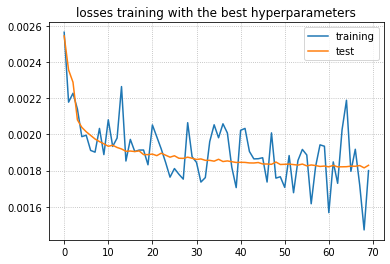

In [39]:
plt.plot(train_loss_record, label='training')
plt.plot(val_loss_record, label='test')
plt.legend()
plt.grid(linestyle=":")
plt.title("losses training with the best hyperparameters")
plt.show()

# Comparison on reconstructed samples

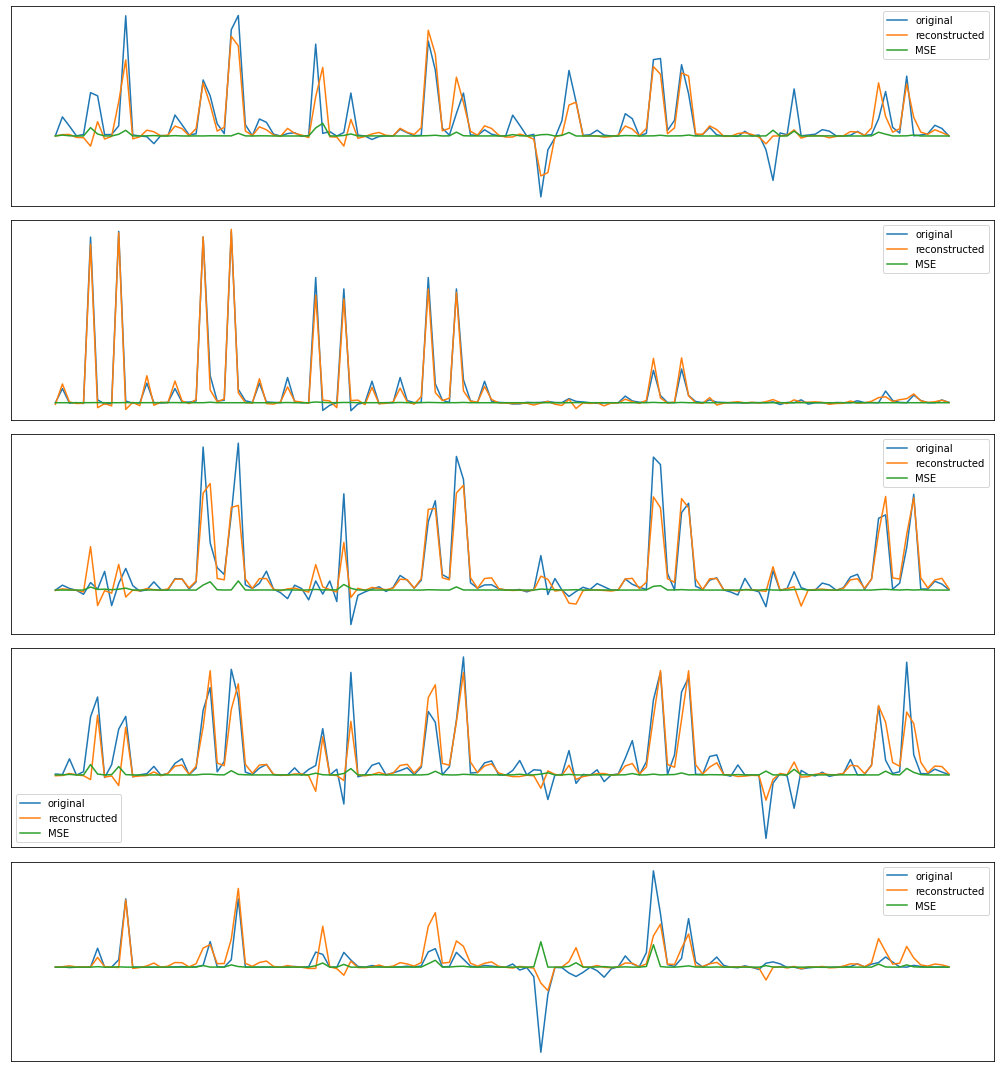

In [95]:
best_encoder = encoder
best_decoder = decoder

rows = 5
fig, ax = plt.subplots(rows, 1, figsize=(14,15))
for i in range(rows):
    img = random.choice(train_dataset_reduced)
    img = img.unsqueeze(0).to(device)
    best_encoder.eval()
    best_decoder.eval()
    with torch.no_grad():
        rec_img  = best_decoder(best_encoder(img))
    ax[i].plot(img.cpu().squeeze().numpy().reshape(128,), label='original')
    ax[i].plot(rec_img.cpu().squeeze().numpy().reshape(128,), label='reconstructed')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].plot((rec_img.cpu().squeeze().numpy().reshape(128,)-img.cpu().squeeze().numpy().reshape(128,))**2, label='MSE')
    ax[i].legend()

plt.tight_layout()